# 02506 Week 10, CNN for image segmentation
*Mini UNet*

This is a notebook for exercise on segmentation using UNet-like architecture.

To enable GPU in google Colab, change the settings in under Edit -> Notebook Settings!

Course note specifies the task for this exercise. Some of the tasks are:
1.   Get familiar with the code. Run all cells and make sure you have an idea of what's happening.
2.   The segmentation network in this notebook is inspired by UNet, but smaller. Based on the code, draw architecture of this network. That is, produce an image similar to [this](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png), but with dimensions as used in the exercise.
3.   The network is designed to take image patches of size 128-by-128. But being fully convolutional, it can also take images of other sizes, as long as donwscaling, upscaling and concatination may be preformed. Make an experiment with passing images of different sizes through the network. 
4.   Look at the weights of the trained network. You  can consider visualizing the convolution kernels. 
5.   Try visualizing network layers (neuron values), when passing one image through the network. The proper way to do to get outputs from layers in pytorch is to use so-called hooks. A less proper but coding-wise easier way of getting hold of network layers is to write a function that resembles the forward method from `Net128` class, but apart from the final prediction also returns the result of intermediate computation. The function call could be  `out, l1, l2, l3, l4, l5 = forward_modified(model, image)`. You can then visualize the layers `l1`, `l2`, `l3`, `l4`, `l5` to see what the network is doing. 
6.   Make an attempt of segmenting a large image.



There are a number of pythorch-specific issues that might help you solve these tasks. A few basic things include:
- Pytorch is based on object-oriented programming. 
- You define a network as a class that inherits from [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module). The class should have an `__init__` method that defines the layers of the network, and a `forward` method that defines how the input tensor is passed through the network.
- A package containing optimizers is [`torch.optim`](https://pytorch.org/docs/stable/optim.html) and an optimizer is constructed as an object of a chosen type. This object is passed the list of parameters to optimize.
- An utility class for loading data is [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). It can handle shuffling and batching if inputs.
- Convolution layers like [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) use convention `(N, C, H, W)` for dimensions of input and output tensors. `N` is the batch size, `C` is the number of channels, `H` and `W` are height and width of the image. 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import PIL.Image
import os

In [2]:
# Retrieve and extract data set, do this only once.
# (To see the file in the directory (side panel), reload the page.)

datadir = 'glands/'  # path to the directory containing data
if not os.path.isdir('glands'):
    !wget -q http://www2.imm.dtu.dk/courses/02506/data/week10/glands.zip
    import shutil
    shutil.unpack_archive('glands.zip', 'glands')

In [3]:
# Make a dataset class.
class GlandData(torch.utils.data.Dataset):
    '''  Dataset which loads all images for training or testing'''
    def __init__(self, data_dir, nr_im, margin_size=20):
        self.images = []
        self.labels = []
        for idx in range(nr_im):
            im = np.array(PIL.Image.open(f'{data_dir}{idx:03d}.png'))
            im = im.transpose(2, 0, 1)/255
            self.images.append(torch.tensor(im, dtype=torch.float32))
            label_im = np.array(PIL.Image.open(f'{data_dir}{idx:03d}_anno.png'))
            label_im = label_im[margin_size:-margin_size, margin_size:-margin_size]/255
            self.labels.append(torch.tensor(label_im, dtype=torch.int64))

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]
    
    def __len__(self):
        return len(self.images)

In [4]:
# Make a training and validation set.
# (This involves loading images and may take some seconds.)

glandTrainData = GlandData(datadir + 'train/train_', 750)
glandTestData = GlandData(datadir + 'test/test_', 240)


Nr. training images: 750
Nr. testing images: 240
Image size: torch.Size([3, 128, 128])
Label size: torch.Size([88, 88])


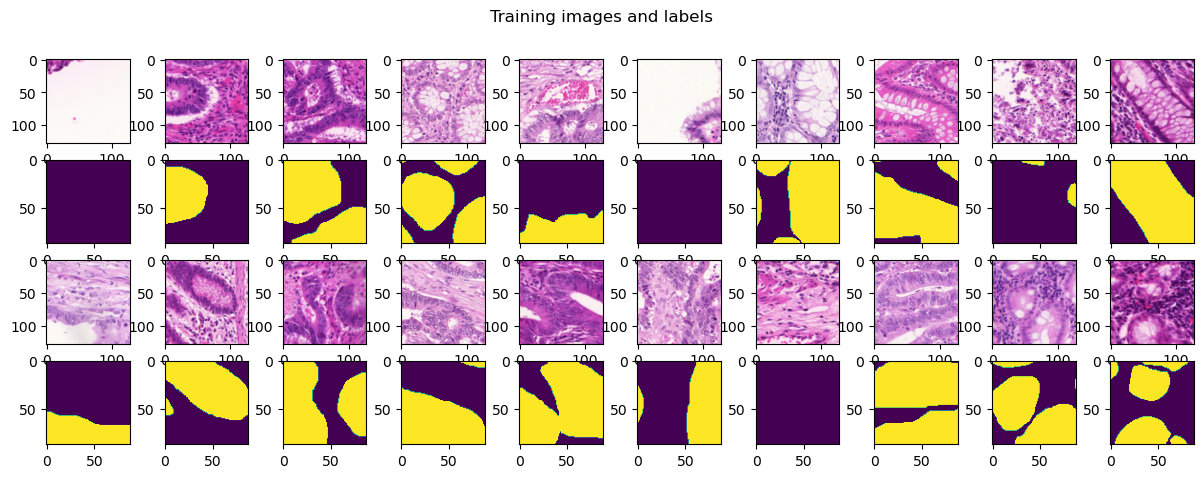

In [5]:
#%% Check whether the implementation of the dataset works as expected.

print(f'Nr. training images: {len(glandTrainData)}')
print(f'Nr. testing images: {len(glandTestData)}')
im, lab = glandTrainData[0]
print(f'Image size: {im.shape}')
print(f'Label size: {lab.shape}')

N = 10
fig, ax = plt.subplots(4, N, figsize=(15,5))
for k in range(2):

    rand_idx = np.random.choice(len(glandTrainData), size=N, replace=False)    
    for n, idx in enumerate(rand_idx):
        
        im, lab = glandTrainData[idx]    
        ax[0+2*k, n].imshow(im.permute(1,2,0))
        ax[1+2*k, n].imshow(lab)
fig.suptitle('Training images and labels')
plt.show()

In [10]:
#%% Make model class.
class UNet128(torch.nn.Module):
    """Takes in patches of 128^2 RGB, returns 88^2"""
    
    def __init__(self, out_channels=2):
        super().__init__()

        # Learnable
        self.conv1A = torch.nn.Conv2d(3, 8, 3)  
        self.conv1B = torch.nn.Conv2d(8, 8, 3)  
        self.conv2A = torch.nn.Conv2d(8, 16, 3)  
        self.conv2B = torch.nn.Conv2d(16, 16, 3)  
        self.conv3A = torch.nn.Conv2d(16, 32, 3)  
        self.conv3B = torch.nn.Conv2d(32, 32, 3)  
        self.conv4A = torch.nn.Conv2d(32, 16, 3)  
        self.conv4B = torch.nn.Conv2d(16, 16, 3)  
        self.conv5A = torch.nn.Conv2d(16, 8, 3)  
        self.conv5B = torch.nn.Conv2d(8, 8, 3)  
        self.convfinal = torch.nn.Conv2d(8, out_channels, 1)         
        self.convtrans34 = torch.nn.ConvTranspose2d(32, 16, 2, stride=2) 
        self.convtrans45 = torch.nn.ConvTranspose2d(16, 8, 2, stride=2)
        
        # Convenience
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2, 2)        
       
    def forward(self, x):
 
        # Down, keeping layer outputs we'll need later.
        l1 = self.relu(self.conv1B(self.relu(self.conv1A(x))))
        l2 = self.relu(self.conv2B(self.relu(self.conv2A(self.pool(l1)))))
        out = self.relu(self.conv3B(self.relu(self.conv3A(self.pool(l2))))) 
        
        # Up, now we overwritte out in each step.
        out = torch.cat([self.convtrans34(out), l2[:,:,4:-4,4:-4]], dim=1)
        out = self.relu(self.conv4B(self.relu(self.conv4A(out))))
        out = torch.cat([self.convtrans45(out), l1[:,:,16:-16,16:-16]], dim=1)      
        out = self.relu(self.conv5B(self.relu(self.conv5A(out))))
   
         # Finishing
        out = self.convfinal(out)
  
        return out

In [11]:
# Figure out whether to use cpu or cuda.

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('Using cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print('Using mps')
else:
    device = torch.device('cpu')
    print('Using cpu')

Using mps


In [12]:
# Initiate the model, dataloaders and optimizer.

lr = 0.0001
nr_epochs = 50

#  Loaders for training and testing set
trainloader = torch.utils.data.DataLoader(glandTrainData,
                                          batch_size=10,
                                          shuffle=True,
                                          drop_last=True)
testloader = torch.utils.data.DataLoader(glandTestData,
                                          batch_size=20)
model = UNet128().to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

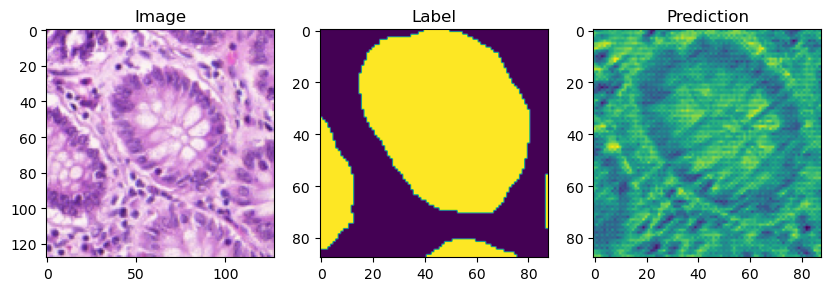

In [13]:
# Prepare for book-keeping during training.
epoch_losses = []
batch_losses = []
test_losses = []

# Pick an image to show how predictions change.
i = 50
im, lb = glandTrainData[i]
with torch.no_grad():
  lgt = model(im.unsqueeze(0).to(device))
  prob = torch.nn.functional.softmax(lgt, dim=1)

fig, ax = plt.subplots(1, 3, figsize=(10,5))
ax[0].imshow(im.permute(1,2,0))
ax[0].set_title('Image')
ax[1].imshow(lb)
ax[1].set_title('Label')
ax[2].imshow(prob[0,1].cpu().detach())
ax[2].set_title('Prediction')
plt.show()

Epoch 0/50, loss 0.7073912239074707
Epoch 1/50, loss 0.7001077993710836
Epoch 2/50, loss 0.6954323569933574
Epoch 3/50, loss 0.6944602251052856
Epoch 4/50, loss 0.693176821867625
Epoch 5/50, loss 0.6917122093836466
Epoch 6/50, loss 0.688040684858958
Epoch 7/50, loss 0.6761377286911011
Epoch 8/50, loss 0.6593494447072347
Epoch 9/50, loss 0.6520777948697408


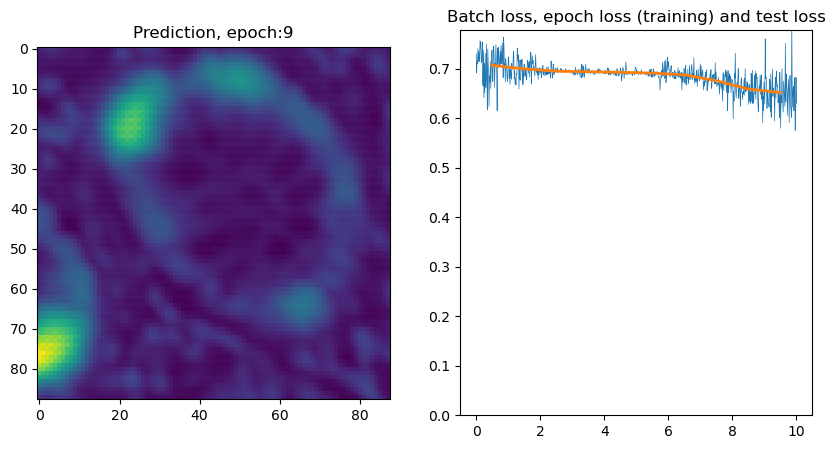

Epoch 10/50, loss 0.6509231758117676
Epoch 11/50, loss 0.6425789658228557
Epoch 12/50, loss 0.6398764316240947
Epoch 13/50, loss 0.6338202619552612
Epoch 14/50, loss 0.6298630181948344
Epoch 15/50, loss 0.6255220746994019
Epoch 16/50, loss 0.6241817887624105
Epoch 17/50, loss 0.6180285127957662
Epoch 18/50, loss 0.620545220375061
Epoch 19/50, loss 0.620871479511261


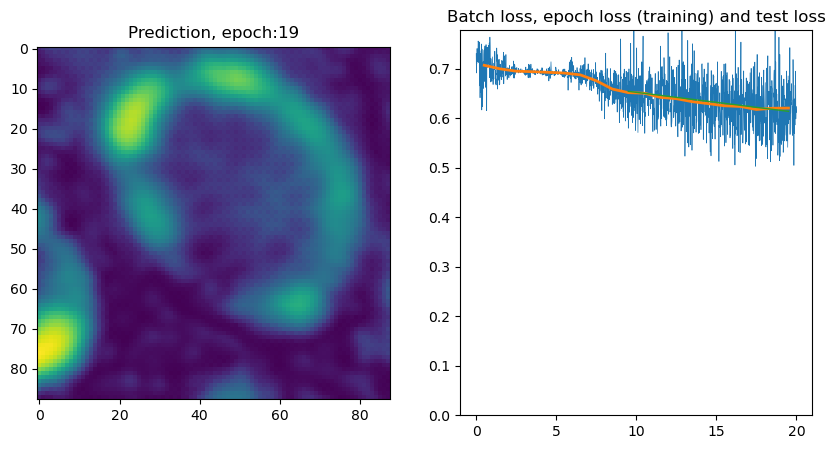

Epoch 20/50, loss 0.6123454948266347
Epoch 21/50, loss 0.6076830339431762
Epoch 22/50, loss 0.6060555255413056
Epoch 23/50, loss 0.6051979978879293
Epoch 24/50, loss 0.603935409784317
Epoch 25/50, loss 0.597811552286148
Epoch 26/50, loss 0.5957334585984548
Epoch 27/50, loss 0.588968133131663
Epoch 28/50, loss 0.5880457814534505
Epoch 29/50, loss 0.5766266421477


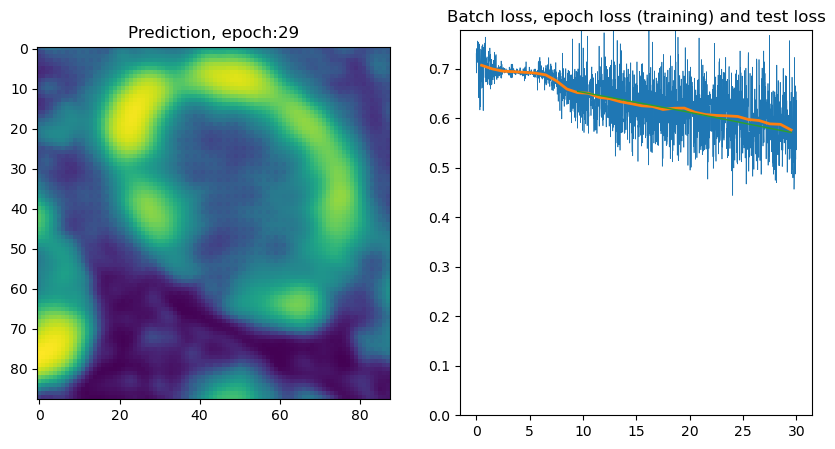

Epoch 30/50, loss 0.5696010144551595
Epoch 31/50, loss 0.5711939144134521
Epoch 32/50, loss 0.5607645003000895
Epoch 33/50, loss 0.5507193263371786
Epoch 34/50, loss 0.5500079417228698
Epoch 35/50, loss 0.5446665489673614
Epoch 36/50, loss 0.5370106438795725
Epoch 37/50, loss 0.5463914783795675
Epoch 38/50, loss 0.5285569878419241
Epoch 39/50, loss 0.5327253150939941


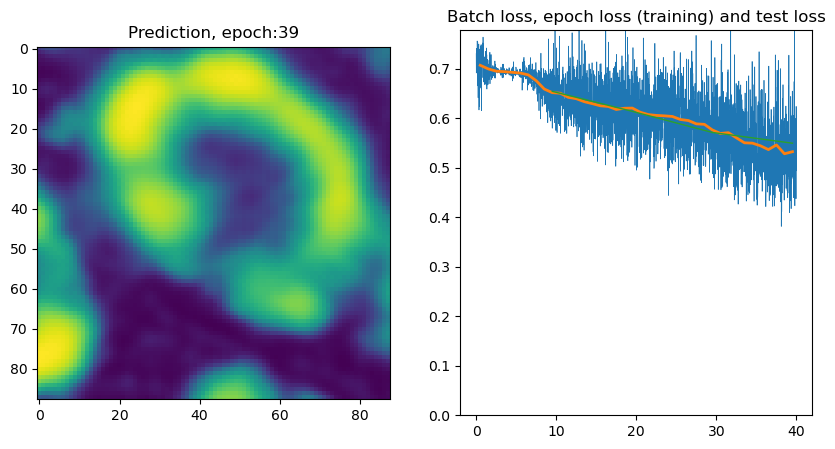

Epoch 40/50, loss 0.5255002391338348
Epoch 41/50, loss 0.5327336390813192
Epoch 42/50, loss 0.5432213580608368
Epoch 43/50, loss 0.5194284951686859
Epoch 44/50, loss 0.5228556867440541
Epoch 45/50, loss 0.5249982329209646
Epoch 46/50, loss 0.5176159179210663
Epoch 47/50, loss 0.5213053274154663
Epoch 48/50, loss 0.5227041844526926
Epoch 49/50, loss 0.5209440302848816


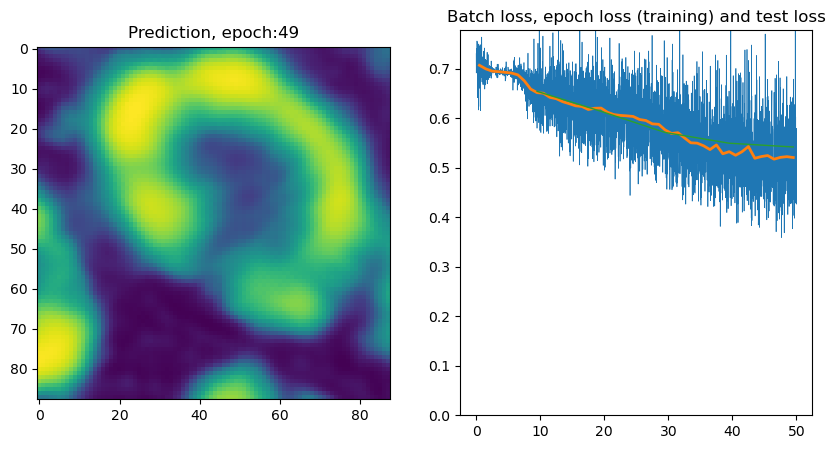

In [14]:
# Train.
for epoch in range(nr_epochs):
    print(f'Epoch {epoch}/{nr_epochs}', end='')

    epoch_loss = 0.0
    for batch in trainloader:
        
        image_batch, label_batch = batch  # unpack the data
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)

        logits_batch = model(image_batch)
        optimizer.zero_grad()
        loss = loss_function(logits_batch, label_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        batch_losses.append(loss.item())

    epoch_losses.append(epoch_loss / len(trainloader))
    print(f', loss {epoch_losses[-1]}')

    if epoch % 10 == 9: 
        #  Book-keeping and visualizing every tenth iterations
        with torch.no_grad():
            lgt = model(im.unsqueeze(0).to(device))
            test_loss = 0
            for batch in testloader:
                image_batch, label_batch = batch  # unpack the data
                image_batch = image_batch.to(device)
                label_batch = label_batch.to(device)
                logits_batch = model(image_batch)
                loss = loss_function(logits_batch, label_batch)
                test_loss += loss.item()
            test_losses.append(test_loss / len(testloader))
                
        prob = torch.nn.functional.softmax(lgt, dim=1)
    
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(prob[0,1].cpu().detach())
        ax[0].set_title(f'Prediction, epoch:{len(epoch_losses) - 1}')
    
        ax[1].plot(np.linspace(0, len(epoch_losses), len(batch_losses)), 
                     batch_losses, lw=0.5)
        ax[1].plot(np.arange(len(epoch_losses)) + 0.5, epoch_losses, lw=2)
        ax[1].plot(np.linspace(9.5, len(epoch_losses)-0.5, len(test_losses)), 
                     test_losses, lw=1)
        ax[1].set_title('Batch loss, epoch loss (training) and test loss')
        ax[1].set_ylim(0, 1.1*max(epoch_losses + test_losses))
        plt.show()

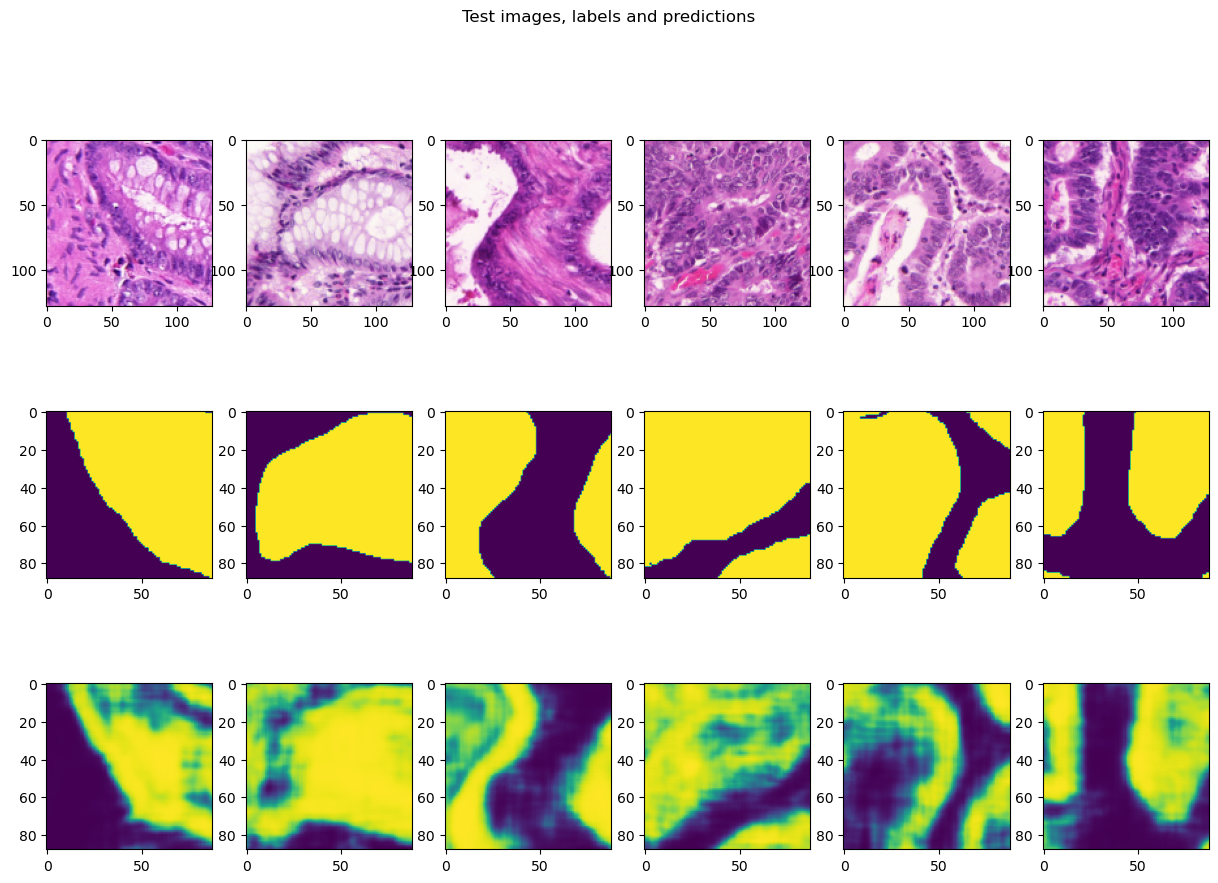

In [19]:
#%%  Show predictions for a few images from the test set.

idxs = [19, 50, 61, 100, 151, 230]
fig, ax = plt.subplots(3, len(idxs), figsize=(15, 10))

for n, idx in enumerate(idxs):
    im_val, lb_val = glandTestData[idx]
    with torch.no_grad():
        lgt_val = model(im_val.unsqueeze(0).to(device))
    prob_val = torch.nn.functional.softmax(lgt_val, dim=1)
    
    ax[0, n].imshow(im_val.permute(1,2,0))
    ax[1, n].imshow(lb_val)
    ax[2, n].imshow(prob_val[0,1].cpu().detach())
fig.suptitle('Test images, labels and predictions')
plt.show()

In [18]:
#  Instead of training, you can also load the saved model parameters obtained by
#  training for 500 epochs. After loading the parameters, run the cell above.
if not os.path.isfile('checkpoint_500.pth'):
    !wget 'http://www2.imm.dtu.dk/courses/02506/data/week10/checkpoint_500.pth' -q
model.load_state_dict(torch.load('checkpoint_500.pth')['model_statedict'])
optimizer.load_state_dict(torch.load('checkpoint_500.pth')['optimizer_statedict'])